In [86]:
import numpy as np
import pandas as pd
import pickle as pkl
import operator
import numbers
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns 
import scipy.stats as ss
import matplotlib.pyplot as plt
%matplotlib inline

In [105]:
data_path = '/Users/leo/Desktop/DSGA-3001/Project/data/'
train = pd.read_csv(data_path+'application_train.csv')

In [106]:
print(train.shape)

(307511, 122)


In [4]:
# 0 - paid
# 1 - unpaid
train.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
train.columns.values

array(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3',

## Target distribution

In [6]:
train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

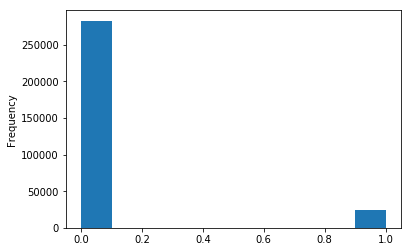

In [7]:
# imbalanced data
train['TARGET'].astype(int).plot.hist()

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


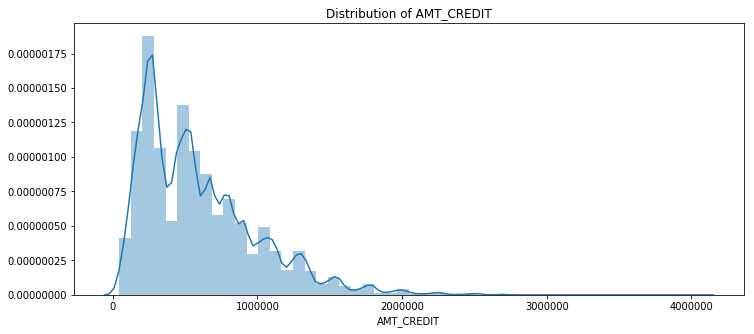

In [8]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_CREDIT")
ax = sns.distplot(train["AMT_CREDIT"])

## Missing Value

#### XGBoost that can handle missing values with no need for imputation.

In [89]:
# Create NA Count DataFrame
nacount = pd.DataFrame(train.isna().sum())
nacount.columns = ['Count']
nacount = nacount[(nacount.T != 0).any()]
nacount['Percentage(%)'] = nacount['Count']/len(train)*100

In [90]:
nacount.head()

,Count,Percentage(%)
AMT_ANNUITY,12,0.003902
AMT_GOODS_PRICE,278,0.090403
NAME_TYPE_SUITE,1292,0.420148
OWN_CAR_AGE,202929,65.990810
OCCUPATION_TYPE,96391,31.345545


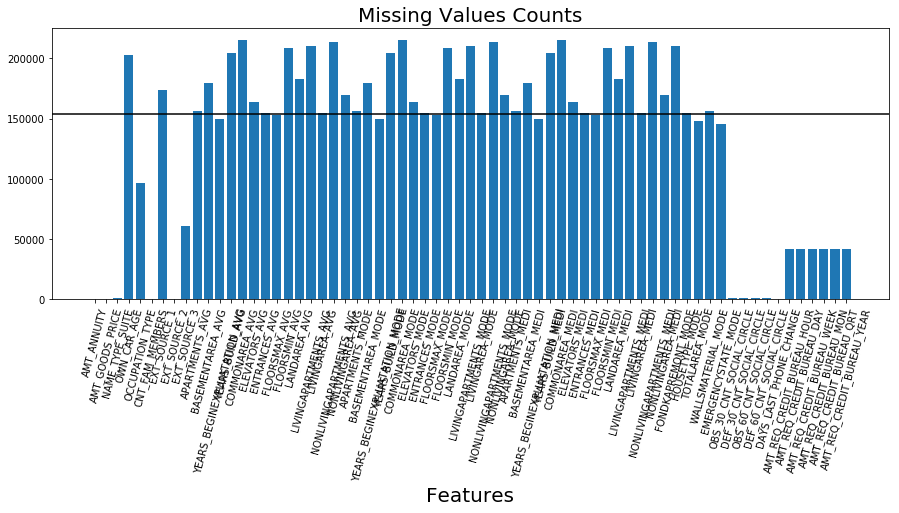

In [91]:
plt.figure(figsize = (15,5))
plt.bar(nacount.index,height = nacount['Count'])
plt.xticks(rotation=75)
plt.xlabel('Features', fontsize = 20)
plt.title('Missing Values Counts', fontsize = 20)
plt.axhline(y=train.shape[0]/2, color='black', linestyle='-')
## above: missing more than 50% of data
plt.show()

## Retrieve columns with more than half missing

In [93]:
nacount_filtered = nacount[nacount['Percentage(%)']>=50]

In [94]:
nacount_filtered.sort_index()

,Count,Percentage(%)
APARTMENTS_AVG,156061,50.749729
APARTMENTS_MEDI,156061,50.749729
APARTMENTS_MODE,156061,50.749729
BASEMENTAREA_AVG,179943,58.515956
BASEMENTAREA_MEDI,179943,58.515956
BASEMENTAREA_MODE,179943,58.515956
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_MODE,214865,69.872297
ELEVATORS_AVG,163891,53.295980


In [95]:
filter_corr = nacount_filtered.index.tolist()
filter_corr.append("TARGET")

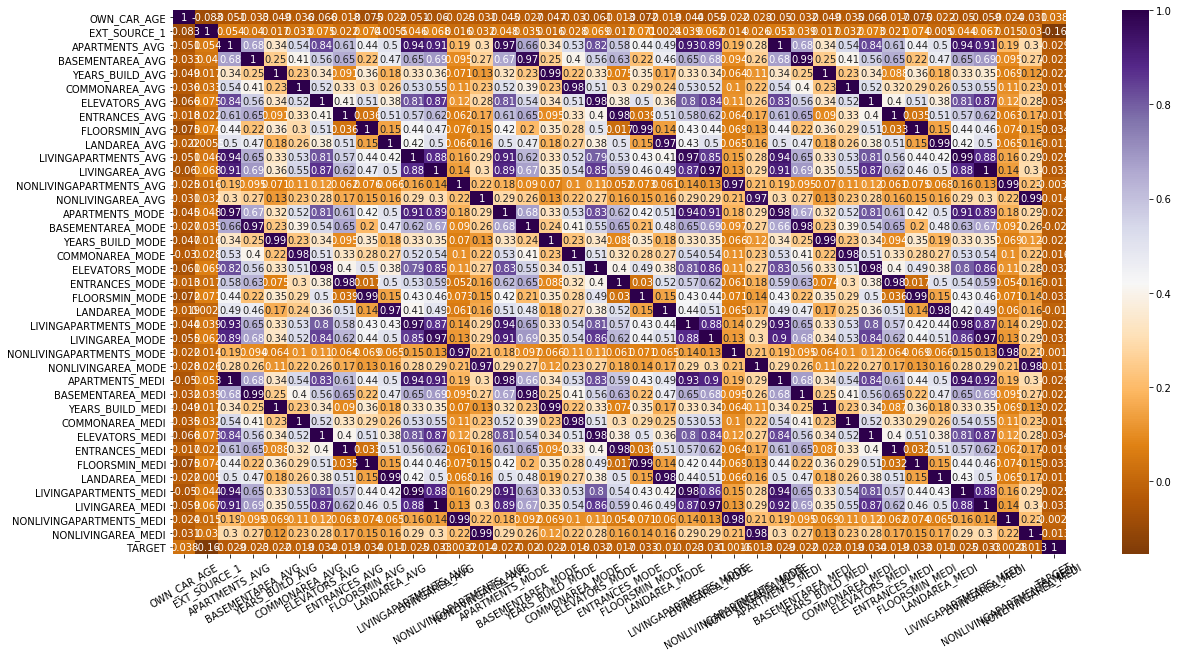

In [66]:
# corr = train[filter_corr].corr()
# fig, ax = plt.subplots(figsize=(20,10))
# heatmap = sns.heatmap(corr, ax=ax, annot=True, cmap="PuOr")
# heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=30)
# plt.show()

In [96]:
# From those missing more than 50%, select those features correlated with Target
corr.iloc[-1,:][np.abs(corr.iloc[-1,:].sort_values()) > 0.1]

EXT_SOURCE_1   -0.155317
TARGET          1.000000
Name: TARGET, dtype: float64

In [97]:
drop_label = nacount_filtered.index.values.tolist()
drop_label.remove('EXT_SOURCE_1')
# Keep Median values, drop mode and avg
drop_label1 = [x for x in drop_label if 'MEDI' not in x]

In [98]:
drop_label1

['OWN_CAR_AGE',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE']

In [107]:
print(len(drop_label1))
print(train.shape)

28
(307511, 122)


In [108]:
train = train.drop(labels = drop_label1, axis = 1)

In [109]:
# Drop 28 columns from 122 columns
# 94 remains
print(train.shape)

(307511, 94)


In [137]:
train.isna().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
FLAG_OWN_REALTY                   0
CNT_CHILDREN                      0
AMT_INCOME_TOTAL                  0
AMT_CREDIT                        0
AMT_ANNUITY                      12
AMT_GOODS_PRICE                 278
NAME_TYPE_SUITE                1292
NAME_INCOME_TYPE                  0
NAME_EDUCATION_TYPE               0
NAME_FAMILY_STATUS                0
NAME_HOUSING_TYPE                 0
REGION_POPULATION_RELATIVE        0
DAYS_BIRTH                        0
DAYS_EMPLOYED                     0
DAYS_REGISTRATION                 0
DAYS_ID_PUBLISH                   0
FLAG_MOBIL                        0
FLAG_EMP_PHONE                    0
FLAG_WORK_PHONE                   0
FLAG_CONT_MOBILE                  0
FLAG_PHONE                        0
FLAG_EMAIL                        0
OCCUPATION_TYPE             

In [116]:
train.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [165]:
object_type_col = train.dtypes[train.dtypes == 'object'].index.tolist()
int64_type_col = train.dtypes[train.dtypes == 'int64'].index.tolist()
float64_type_col = train.dtypes[train.dtypes == 'float64'].index.tolist()
print(len(object_type_col), len(int64_type_col), len(float64_type_col))

13 41 40


In [169]:
object_type_col

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'EMERGENCYSTATE_MODE']

In [170]:
int64_type_col

['SK_ID_CURR',
 'TARGET',
 'CNT_CHILDREN',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21']

In [171]:
float64_type_col

['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_REGISTRATION',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'YEARS_BEGINEXPLUATATION_AVG',
 'FLOORSMAX_AVG',
 'YEARS_BEGINEXPLUATATION_MODE',
 'FLOORSMAX_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'TOTALAREA_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [167]:
## retrieve categorical features from int64_col
cat_in_int64 = []
for item in int64_type_col:
    if ('FLAG_' in item) or ('REG_' in item) or ('LIVE_' in item) or ('HOUR_APPR' in item):
        cat_in_int64.append(item)
# [x for x in int64_type_col if ('FLAG_' or 'REG')]        

In [168]:
cat_feature = object_type_col + cat_in_int64

In [192]:
num_feature = [x for x in train.columns.values.tolist() if x not in cat_feature]
num_feature.remove('SK_ID_CURR')
num_feature.remove('TARGET')

### At this stage, num_features and cat_features are filtered out. 
### Index and Target are excluded

In [205]:
print(len(num_feature),len(cat_feature))

46 46


In [206]:
# Check missing values inside category features
train[cat_feature].isna().sum()

NAME_CONTRACT_TYPE                  0
CODE_GENDER                         0
FLAG_OWN_CAR                        0
FLAG_OWN_REALTY                     0
NAME_TYPE_SUITE                  1292
NAME_INCOME_TYPE                    0
NAME_EDUCATION_TYPE                 0
NAME_FAMILY_STATUS                  0
NAME_HOUSING_TYPE                   0
OCCUPATION_TYPE                 96391
WEEKDAY_APPR_PROCESS_START          0
ORGANIZATION_TYPE                   0
EMERGENCYSTATE_MODE            145755
FLAG_MOBIL                          0
FLAG_EMP_PHONE                      0
FLAG_WORK_PHONE                     0
FLAG_CONT_MOBILE                    0
FLAG_PHONE                          0
FLAG_EMAIL                          0
HOUR_APPR_PROCESS_START             0
REG_REGION_NOT_LIVE_REGION          0
REG_REGION_NOT_WORK_REGION          0
LIVE_REGION_NOT_WORK_REGION         0
REG_CITY_NOT_LIVE_CITY              0
REG_CITY_NOT_WORK_CITY              0
LIVE_CITY_NOT_WORK_CITY             0
FLAG_DOCUMEN

In [209]:
## the most missing class - flag as unknown - 96391 missing
## fill missing values with Unknown
train.isna().sum()['OCCUPATION_TYPE']
train['OCCUPATION_TYPE'].fillna('Unknown', inplace=True)

In [237]:
## Drop the column - 145755 missing
## check correlation
train.isna().sum()['EMERGENCYSTATE_MODE']

145755

In [229]:
confusion_matrix = pd.crosstab(train['EMERGENCYSTATE_MODE'], train['TARGET'])

In [230]:
confusion_matrix

TARGET,0,1
EMERGENCYSTATE_MODE,,
No,148324,11104
Yes,2105,223


In [235]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [236]:
cramers_corrected_stat(confusion_matrix)

0.011840632382893481

In [238]:
train = train.drop(labels = 'EMERGENCYSTATE_MODE', axis = 1)

In [274]:
cat_feature.remove('EMERGENCYSTATE_MODE')

In [275]:
len(train.columns)

93

In [61]:
train.isna().sum()['NAME_TYPE_SUITE']
## Fill with 'unaccommpanied'/ 'unknown' -- 1292 missing

1292

In [262]:
train['NAME_TYPE_SUITE'].value_counts()

Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Others               1292
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64

In [271]:
train['NAME_TYPE_SUITE'].fillna('Others', inplace=True)
train['NAME_TYPE_SUITE'].loc[train['NAME_TYPE_SUITE'] == 'Other_B'] = 'Others'
train['NAME_TYPE_SUITE'].loc[train['NAME_TYPE_SUITE'] == 'Other_A'] = 'Others'
train['NAME_TYPE_SUITE'].loc[train['NAME_TYPE_SUITE'] == 'Group of people'] = 'Others'

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [272]:
train['NAME_TYPE_SUITE'].value_counts()

Unaccompanied      248526
Family              40149
Spouse, partner     11370
Others               4199
Children             3267
Name: NAME_TYPE_SUITE, dtype: int64

In [276]:
train[cat_feature].isna().sum()

NAME_CONTRACT_TYPE             0
CODE_GENDER                    0
FLAG_OWN_CAR                   0
FLAG_OWN_REALTY                0
NAME_TYPE_SUITE                0
NAME_INCOME_TYPE               0
NAME_EDUCATION_TYPE            0
NAME_FAMILY_STATUS             0
NAME_HOUSING_TYPE              0
OCCUPATION_TYPE                0
WEEKDAY_APPR_PROCESS_START     0
ORGANIZATION_TYPE              0
FLAG_MOBIL                     0
FLAG_EMP_PHONE                 0
FLAG_WORK_PHONE                0
FLAG_CONT_MOBILE               0
FLAG_PHONE                     0
FLAG_EMAIL                     0
HOUR_APPR_PROCESS_START        0
REG_REGION_NOT_LIVE_REGION     0
REG_REGION_NOT_WORK_REGION     0
LIVE_REGION_NOT_WORK_REGION    0
REG_CITY_NOT_LIVE_CITY         0
REG_CITY_NOT_WORK_CITY         0
LIVE_CITY_NOT_WORK_CITY        0
FLAG_DOCUMENT_2                0
FLAG_DOCUMENT_3                0
FLAG_DOCUMENT_4                0
FLAG_DOCUMENT_5                0
FLAG_DOCUMENT_6                0
FLAG_DOCUM

### all cat_features now have non-missing values
### take care of num_features

In [278]:
train[num_feature].isna().sum()

CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
CNT_FAM_MEMBERS                      2
REGION_RATING_CLIENT                 0
REGION_RATING_CLIENT_W_CITY          0
EXT_SOURCE_1                    173378
EXT_SOURCE_2                       660
EXT_SOURCE_3                     60965
YEARS_BEGINEXPLUATATION_AVG     150007
FLOORSMAX_AVG                   153020
YEARS_BEGINEXPLUATATION_MODE    150007
FLOORSMAX_MODE                  153020
APARTMENTS_MEDI                 156061
BASEMENTAREA_MEDI               179943
YEARS_BEGINEXPLUATATION_MEDI    150007
YEARS_BUILD_MEDI                204488
COMMONAREA_MEDI                 214865
ELEVATORS_MEDI           

In [ ]:
train

## Bar chart Example - How many children does applicants have

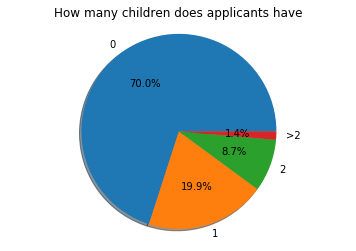

In [16]:
count_children = train['CNT_CHILDREN'].value_counts()
sizes = count_children.values
sizes_ = sizes[:3]
sizes_ = np.append(sizes_, sizes[3:].sum())
labels = count_children.index
labels_ = labels[:3]
labels_ = np.append(labels_,'>2')
fig1, ax1 = plt.subplots()
ax1.pie(sizes_, labels=labels_, autopct='%1.1f%%',
        shadow=True, startangle=0)
ax1.axis('equal') 
ax1.set_title('How many children does applicants have')
plt.show()

## Rescale the numeric feature

In [34]:
def feature_normalization(dataset):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    selected = dataset.select_dtypes(include=numerics)
    # exclude SK_ID_CURR and target
    # exclude FLAG_ish indicator variables
    columns_sel = selected.columns[~selected.columns.str.contains(pat = 'FLAG_|REG_|LIVE_|HOUR_APPR_PROCESS_START')][2:]
    print(columns_sel.values)
    print(len(columns_sel))
    dataset[columns_sel] = (dataset[columns_sel] - dataset[columns_sel].min(axis=0))/ \
    (dataset[columns_sel].max(axis=0) - dataset[columns_sel].min(axis=0))
#     df[columns_sel] = pd.DataFrame(scaler.fit_transform(df[columns_sel]))
    return dataset

In [35]:
train = feature_normalization(train)

['CNT_CHILDREN' 'AMT_INCOME_TOTAL' 'AMT_CREDIT' 'AMT_ANNUITY'
 'AMT_GOODS_PRICE' 'REGION_POPULATION_RELATIVE' 'DAYS_BIRTH'
 'DAYS_EMPLOYED' 'DAYS_REGISTRATION' 'DAYS_ID_PUBLISH' 'OWN_CAR_AGE'
 'CNT_FAM_MEMBERS' 'REGION_RATING_CLIENT' 'REGION_RATING_CLIENT_W_CITY'
 'EXT_SOURCE_1' 'EXT_SOURCE_2' 'EXT_SOURCE_3' 'APARTMENTS_AVG'
 'BASEMENTAREA_AVG' 'YEARS_BEGINEXPLUATATION_AVG' 'YEARS_BUILD_AVG'
 'COMMONAREA_AVG' 'ELEVATORS_AVG' 'ENTRANCES_AVG' 'FLOORSMAX_AVG'
 'FLOORSMIN_AVG' 'LANDAREA_AVG' 'LIVINGAPARTMENTS_AVG' 'LIVINGAREA_AVG'
 'NONLIVINGAPARTMENTS_AVG' 'NONLIVINGAREA_AVG' 'APARTMENTS_MODE'
 'BASEMENTAREA_MODE' 'YEARS_BEGINEXPLUATATION_MODE' 'YEARS_BUILD_MODE'
 'COMMONAREA_MODE' 'ELEVATORS_MODE' 'ENTRANCES_MODE' 'FLOORSMAX_MODE'
 'FLOORSMIN_MODE' 'LANDAREA_MODE' 'LIVINGAPARTMENTS_MODE'
 'LIVINGAREA_MODE' 'NONLIVINGAPARTMENTS_MODE' 'NONLIVINGAREA_MODE'
 'APARTMENTS_MEDI' 'BASEMENTAREA_MEDI' 'YEARS_BEGINEXPLUATATION_MEDI'
 'YEARS_BUILD_MEDI' 'COMMONAREA_MEDI' 'ELEVATORS_MEDI' 'ENTRANCES_

In [50]:
# 'HOUR_APPR_PROCESS_START' 'REG_REGION_NOT_LIVE_REGION'
#  'REG_REGION_NOT_WORK_REGION' 'LIVE_REGION_NOT_WORK_REGION'
#  'REG_CITY_NOT_LIVE_CITY' 'REG_CITY_NOT_WORK_CITY'
#  'LIVE_CITY_NOT_WORK_CITY'
# Though int, but should be removed as well

In [51]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0.0,0.001512,0.090287,0.090032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04
1,100003,0,Cash loans,F,N,N,0.0,0.002089,0.311736,0.132924,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,100004,0,Revolving loans,M,Y,Y,0.0,0.000358,0.022472,0.020025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
3,100006,0,Cash loans,F,N,Y,0.0,0.000935,0.066837,0.109477,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0.0,0.000819,0.116854,0.078975,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00


## Create dummy variables

In [23]:
train_with_dummy = pd.get_dummies(train)

In [24]:
train_with_dummy.shape

(307511, 246)

In [25]:
train_with_dummy.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,1,0.0,0.001512,0.090287,0.090032,0.077441,0.256321,0.888839,0.045086,...,0,0,0,0,0,0,1,0,1,0
1,100003,0,0.0,0.002089,0.311736,0.132924,0.271605,0.045016,0.477114,0.043648,...,0,1,0,0,0,0,0,0,1,0
2,100004,0,0.0,0.000358,0.022472,0.020025,0.023569,0.134897,0.348534,0.046161,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0.0,0.000935,0.066837,0.109477,0.063973,0.107023,0.350846,0.038817,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0.0,0.000819,0.116854,0.078975,0.117845,0.392880,0.298591,0.038820,...,0,0,0,0,0,0,0,0,0,0


## Anomalies detection

In [26]:
(train_with_dummy['DAYS_BIRTH'] / -365).describe()
# seems fine

count    307511.000000
mean         -0.001420
std           0.000674
min          -0.002740
25%          -0.001979
50%          -0.001464
75%          -0.000857
max          -0.000000
Name: DAYS_BIRTH, dtype: float64

In [41]:
(train_with_dummy['DAYS_EMPLOYED']).describe()

# (train_with_dummy['DAYS_EMPLOYED'] / -365).describe()
# (train_with_dummy['DAYS_EMPLOYED'] / -365).plot.hist()

count    252137.000000
mean          0.040526
std           0.006103
min           0.000000
25%           0.038462
50%           0.042448
75%           0.044747
max           0.046749
Name: DAYS_EMPLOYED, dtype: float64

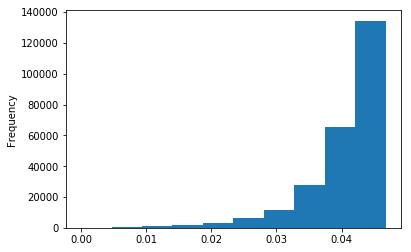

In [40]:
(train_with_dummy['DAYS_EMPLOYED']).plot.hist()

In [35]:
train_with_dummy['DAYS_EMPLOYED_ANOM'] = train_with_dummy["DAYS_EMPLOYED"] == 1

In [36]:
train_with_dummy['DAYS_EMPLOYED'].replace({1: np.nan}, inplace = True)

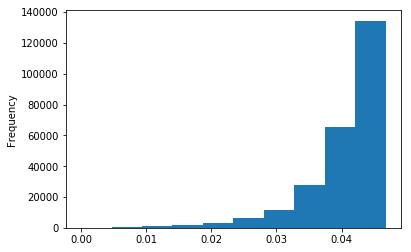

In [37]:
(train_with_dummy['DAYS_EMPLOYED'] ).plot.hist()

In [38]:
## 18% of data is abnormal due to days-employed
sum(train_with_dummy['DAYS_EMPLOYED_ANOM']==True)/train_with_dummy.shape[0]

0.18007160719453938

In [42]:
# (train_with_dummy['DAYS_EMPLOYED']/-365).describe()
(train_with_dummy['DAYS_EMPLOYED']).describe()

count    252137.000000
mean          0.040526
std           0.006103
min           0.000000
25%           0.038462
50%           0.042448
75%           0.044747
max           0.046749
Name: DAYS_EMPLOYED, dtype: float64

In [43]:
# fill in median of days-employed
train_with_dummy['DAYS_EMPLOYED'].fillna((train_with_dummy['DAYS_EMPLOYED'].median()), inplace=True)

In [44]:
train_with_dummy.isna().sum()

SK_ID_CURR                                       0
TARGET                                           0
CNT_CHILDREN                                     0
AMT_INCOME_TOTAL                                 0
AMT_CREDIT                                       0
AMT_ANNUITY                                     12
AMT_GOODS_PRICE                                278
REGION_POPULATION_RELATIVE                       0
DAYS_BIRTH                                       0
DAYS_EMPLOYED                                    0
DAYS_REGISTRATION                                0
DAYS_ID_PUBLISH                                  0
OWN_CAR_AGE                                 202929
FLAG_MOBIL                                       0
FLAG_EMP_PHONE                                   0
FLAG_WORK_PHONE                                  0
FLAG_CONT_MOBILE                                 0
FLAG_PHONE                                       0
FLAG_EMAIL                                       0
CNT_FAM_MEMBERS                

## Correlation between X and y

In [24]:
correlations = train_with_dummy.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.063368
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

In [25]:
## days-birth has high correlation with target
## bigger, more likely to default
## but days-birth is all negative
## thus younger, more likely to default

## Bin the days-birth

In [26]:
# Age information into a separate dataframe
age_data = train_with_dummy[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / -365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,-9461,25.920548,"(25.0, 30.0]"
1,0,-16765,45.931507,"(45.0, 50.0]"
2,0,-19046,52.180822,"(50.0, 55.0]"
3,0,-19005,52.068493,"(50.0, 55.0]"
4,0,-19932,54.608219,"(50.0, 55.0]"
5,0,-16941,46.413699,"(45.0, 50.0]"
6,0,-13778,37.747945,"(35.0, 40.0]"
7,0,-18850,51.643836,"(50.0, 55.0]"
8,0,-20099,55.065753,"(55.0, 60.0]"
9,0,-14469,39.641096,"(35.0, 40.0]"


In [27]:
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,-8532.795625,23.377522
"(25.0, 30.0]",0.111436,-10155.219250,27.822518
"(30.0, 35.0]",0.102814,-11854.848377,32.479037
"(35.0, 40.0]",0.089414,-13707.908253,37.555913
"(40.0, 45.0]",0.078491,-15497.661233,42.459346
"(45.0, 50.0]",0.074171,-17323.900441,47.462741
"(50.0, 55.0]",0.066968,-19196.494791,52.593136
"(55.0, 60.0]",0.055314,-20984.262742,57.491131
"(60.0, 65.0]",0.052737,-22780.547460,62.412459


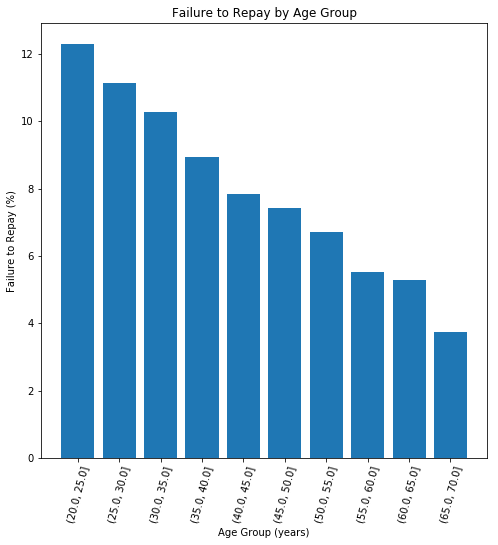

In [28]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

In [29]:
ext_data = train_with_dummy[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,-0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,-0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,-0.205478
DAYS_BIRTH,0.078239,-0.600610,-0.091996,-0.205478,1.000000


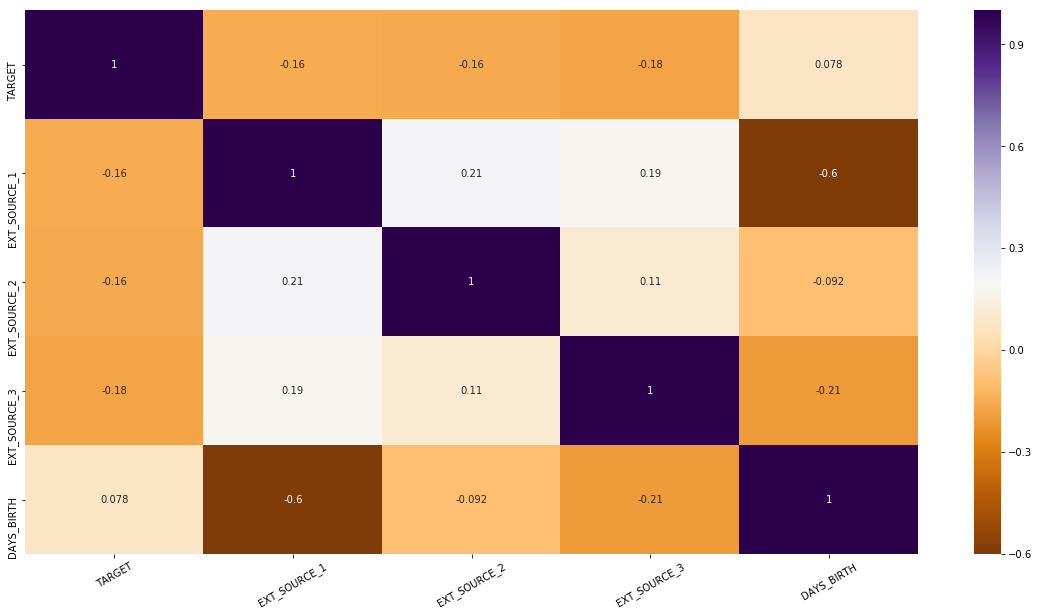

In [30]:
fig, ax = plt.subplots(figsize=(20,10))
heatmap = sns.heatmap(ext_data_corrs, ax=ax, annot=True, cmap="PuOr")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=30)
# plt.savefig(path+'plot/correlationmatrix.eps')
plt.show()

In [31]:
## larger the external source, the more likely they will repay the loan
## ext-1 maybe the age - hihgly correlated

## Domain knowledge feature extraction

In [32]:
## CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
## ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
## CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due
## DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

In [32]:
train_with_dummy['CREDIT_INCOME_PERCENT'] = train_with_dummy['AMT_CREDIT'] / train_with_dummy['AMT_INCOME_TOTAL']
train_with_dummy['ANNUITY_INCOME_PERCENT'] = train_with_dummy['AMT_ANNUITY'] / train_with_dummy['AMT_INCOME_TOTAL']
train_with_dummy['CREDIT_TERM'] = train_with_dummy['AMT_ANNUITY'] / train_with_dummy['AMT_CREDIT']
train_with_dummy['DAYS_EMPLOYED_PERCENT'] = train_with_dummy['DAYS_EMPLOYED'] / train_with_dummy['DAYS_BIRTH']

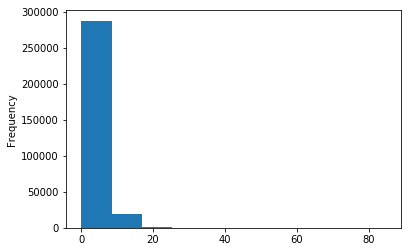

In [33]:
train_with_dummy['CREDIT_INCOME_PERCENT'].plot.hist()

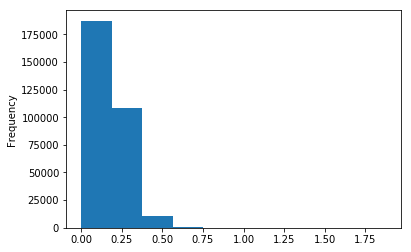

In [34]:
train_with_dummy['ANNUITY_INCOME_PERCENT'].plot.hist()

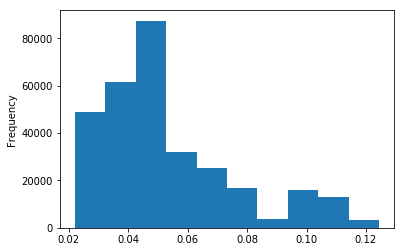

In [35]:
train_with_dummy['CREDIT_TERM'].plot.hist()

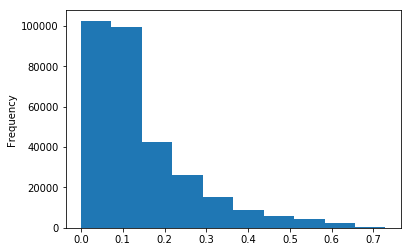

In [36]:
train_with_dummy['DAYS_EMPLOYED_PERCENT'].plot.hist()

In [37]:
train_with_dummy.columns.values

array(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
       'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
       'NONLIVINGAPAR